## Vlasiator - A Global Hybrid-Vlasov Simulation Model 
Vlasiator [@palmroth2018] is an open-source simulation software used to model the behavior of plasma in the Earth's magnetosphere, a region of space where the solar wind interacts with the Earth’s magnetic field. Vlasiator models collisionless space plasma dynamics by solving the 6-dimensional Vlasov equation, using a hybrid-Vlasov approach. It uses a 3D Cartesian grid in real space, with each cell storing another 3D Cartesian grid in velocity space. The velocity mesh contained in each spatial cell in the simulation domain has been represented so far by a sparse grid approach, fundamentally based on an associative container such as a key-value hashtable. Storing a 3D VDF at every spatial cells increases the memory requirements exponentially both during runtime and for storing purposes. Our proposal revolves around developing innovative solutions to compressing the VDFs during runtmime.

![title](images/egi.png)


## VDF Compression


### Let's read in a vdf from a sample file and see what that looks like.

In [3]:
import tools as project_tools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.colors as colors
# plt.rcParams['figure.figsize'] = [7, 7]
import ctypes
import pyzfp,zlib,sys,os
import mlp_compress

Found population proton
Getting offsets for population proton
VDF shape = (50, 50, 50)


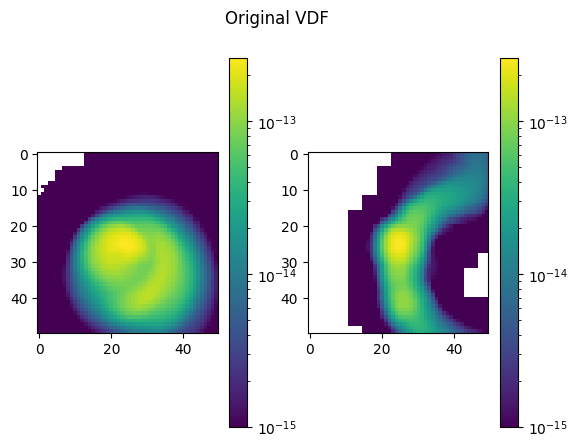

In [4]:
file="/home/kstppd/Desktop/bulk1.0001280.vlsv";cid=356780649;
#Read the VDF into a 3D uniform mesh and plot it
vdf=project_tools.extract_vdf(file,cid,25)
np.save("sample_vdf.bin",np.array(vdf,dtype=np.double));
nx,ny,nz=np.shape(vdf)
print(f"VDF shape = {np.shape(vdf)}")
fig, (ax1, ax2) = plt.subplots(1, 2)
im1=ax1.imshow(vdf[:,:,nz//2],norm=colors.LogNorm(vmin=1e-15))
im2=ax2.imshow(vdf[:,ny//2,:],norm=colors.LogNorm(vmin=1e-15))
plt.colorbar(im1)
plt.colorbar(im2)
fig.suptitle("Original VDF")
plt.show()

### The vdf shown above is sampled on a uniform 3D velocity mesh and contains 64bit floating point numbers that represent the phase space density. We can calculate the total size of this VDF is bytes using ```sys.getsizeof(vdf)```.

In [5]:
vdf_mem=sys.getsizeof(vdf)
num_stored_elements=len(vdf[vdf>1e-15])
print(f"VDF takes {vdf_mem} B.")

VDF takes 500144 B.


### Now in Vlasiator we have countlesss VDFs since there is one per spatial cell. It would be great if we could compress them efficiently. We can try to do so by using zlib which is a form of lossless compression.

Achieved compression ratio using zlib= 1.54.


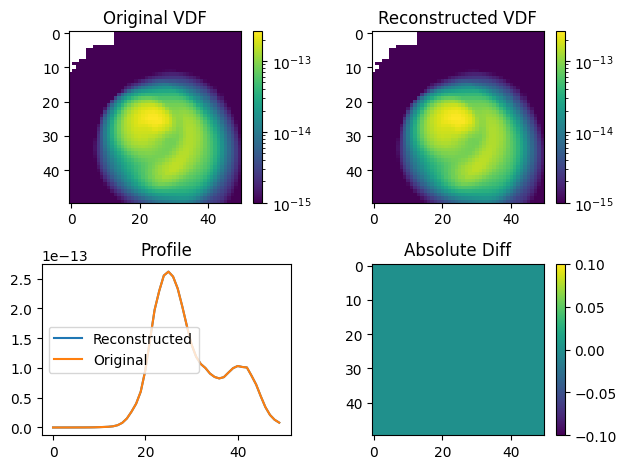

Moment Stats (R,Vm)= (0.0, 0.0) %.
L1,L2 rNorms= (0.0, 0.0).


In [6]:
compressed_vdf = zlib.compress(vdf)
compressed_vdf_mem=len(compressed_vdf)
compression_ratio=vdf_mem/compressed_vdf_mem
print(f"Achieved compression ratio using zlib= {round(compression_ratio,2)}.")
decompressed_vdf = zlib.decompress(compressed_vdf)
recon = np.frombuffer(decompressed_vdf, dtype=vdf.dtype).reshape(vdf.shape)
project_tools.plot_vdfs(vdf,recon)
project_tools.print_comparison_stats(vdf,recon)

### We can use a lossy compression method like zfp[@zfp] to get even higher compression ratios.

Achieved compression ratio using zfp= 87.32.


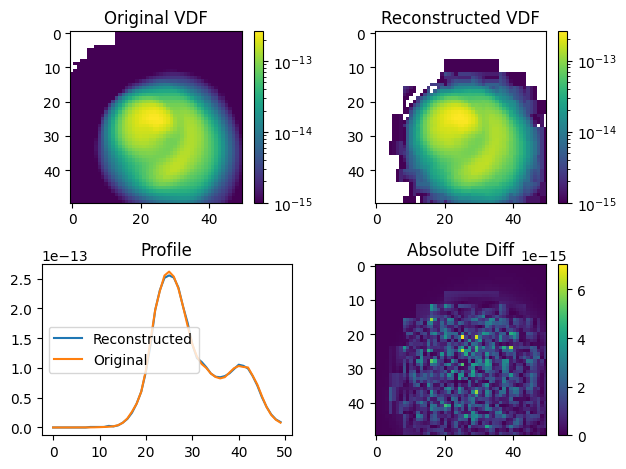

Moment Stats (R,Vm)= (0.083, 0.0) %.
L1,L2 rNorms= (0.046, 0.032).


In [7]:

tolerance = 1e-13
compressed_vdf = pyzfp.compress(vdf, tolerance=tolerance)
compressed_vdf_mem=len(compressed_vdf)
compression_ratio=vdf_mem/compressed_vdf_mem
print(f"Achieved compression ratio using zfp= {round(compression_ratio,2)}.")
recon = pyzfp.decompress(compressed_vdf,vdf.shape,vdf.dtype,tolerance)
project_tools.plot_vdfs(vdf,recon)
project_tools.print_comparison_stats(vdf,recon)

### We will compress the VDF using an MLP. [@park2019]

Reading VDF from sample_vdf.bin
Cost at epoch 0 is 3.8148
Cost at epoch 1 is 0.3508
Cost at epoch 2 is 0.3002
Cost at epoch 3 is 0.2845
Cost at epoch 4 is 0.2751
Cost at epoch 5 is 0.2682
Cost at epoch 6 is 0.2624
Cost at epoch 7 is 0.2580
Cost at epoch 8 is 0.2543
Cost at epoch 9 is 0.2517
Bytes serialized 1032/1032.
Done in 2.43 s.  Compression ratio = 992.06x .


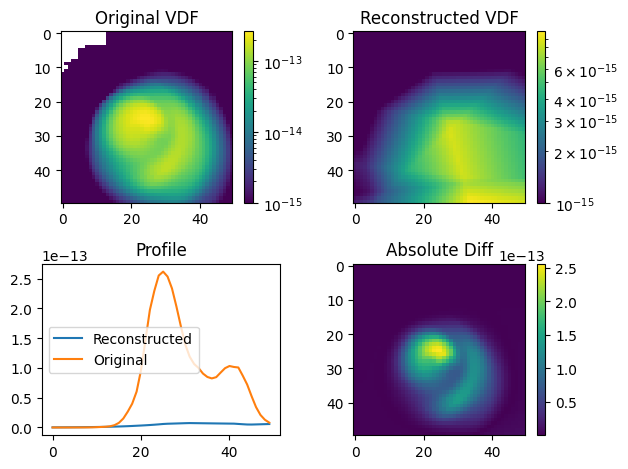

Moment Stats (R,Vm)= (95.046, 9.353) %.
L1,L2 rNorms= (0.776, 3.401).


In [8]:
order=0
epochs=10
n_layers=2
n_neurons=25
recon=mlp_compress.compress("sample_vdf.bin",order,epochs,n_layers,n_neurons)
recon=np.array(recon,dtype=np.double)
recon= np.reshape(recon,np.shape(vdf),order='C')
project_tools.plot_vdfs(vdf,recon)
project_tools.print_comparison_stats(vdf,recon)

### We will compress the VDF using an MLP with Fourier Features. [@2020fourier]

Reading VDF from sample_vdf.bin
Cost at epoch 0 is 0.7541
Cost at epoch 1 is 0.0233
Cost at epoch 2 is 0.0129
Cost at epoch 3 is 0.0100
Cost at epoch 4 is 0.0084
Cost at epoch 5 is 0.0073
Cost at epoch 6 is 0.0066
Cost at epoch 7 is 0.0062
Cost at epoch 8 is 0.0058
Cost at epoch 9 is 0.0056
Cost at epoch 10 is 0.0055
Cost at epoch 11 is 0.0054
Bytes serialized 40432/40432.
Done in 40.75 s.  Compression ratio = 24.75x .


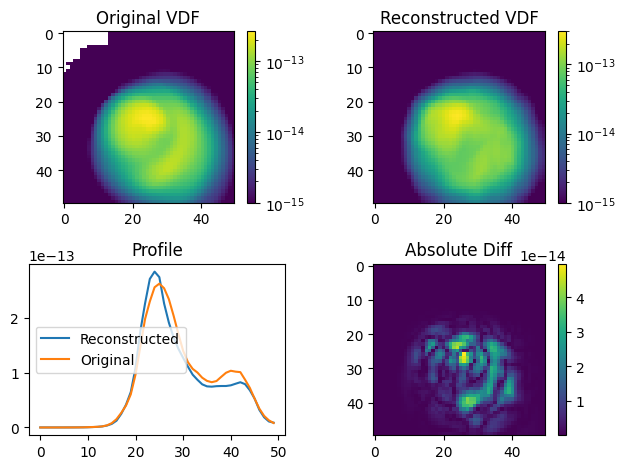

Moment Stats (R,Vm)= (5.207, 0.129) %.
L1,L2 rNorms= (0.13, 0.155).


In [10]:
order=16
epochs=12
n_layers=2
n_neurons=50
recon=mlp_compress.compress("sample_vdf.bin",order,epochs,n_layers,n_neurons)
recon=np.array(recon,dtype=np.double)
recon= np.reshape(recon,np.shape(vdf),order='C')
project_tools.plot_vdfs(vdf,recon)
project_tools.print_comparison_stats(vdf,recon)

### Now we use a CNN to perform the compression.

In [ ]:
"""
Function: train_and_reconstruct

Description:
This function takes an input array and trains a Convolutional Neural Network (CNN) model to reconstruct the input array.
It uses Mean Squared Error (MSE) loss and the Adam optimizer for training.

Inputs:
- input_array (numpy array): The input array to be reconstructed.
- num_epochs (int, optional): The number of training epochs. Default is 30.
- learning_rate (float, optional): The learning rate for the Adam optimizer. Default is 0.001.
Outputs:
    Reconstructed vdf array 
    Size of model in bytes
"""

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv3d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv3d(64, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.conv4(x)
        return x

def train_and_reconstruct(input_array, num_epochs=30, learning_rate=0.001):
    input_tensor = torch.tensor(input_array, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
    model = CNN()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output_tensor = model(input_tensor)
        loss = criterion(output_tensor, input_tensor)
        loss.backward()
        optimizer.step()
        
        if (epoch+1) % 100== 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    with torch.no_grad():
        output_tensor = model(input_tensor)
    reconstructed_array = output_tensor.squeeze(0).squeeze(0).cpu().numpy()
    
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    size = (param_size + buffer_size)   
    return reconstructed_array,size

vdf_temp=vdf.copy()
vdf_temp[vdf_temp<1e-16]=1e-16
vdf_temp = np.log10(vdf_temp)
input_array=vdf_temp
recon,total_size= train_and_reconstruct(input_array,1000)
recon = 10 ** recon
recon[recon <= 1e-16] = 0
vdf_size=nx*ny*nz*8
print(f"Compresion achieved using a CNN = {round(vdf_size/total_size,2)}")
project_tools.plot_vdfs(vdf,recon)
project_tools.print_comparison_stats(vdf,recon)

In [ ]:

### load original 3d vdf and fit Maxwellian
vdf_3d=vdf.copy()
print('loading done')

#### Fit Maxwellian
v_min,v_max,n_bins=0,nx,nx ### define limits and size of velocity axes

amp,ux,uy,uz,vthx,vthy,vthz=1e-14,nx,nx,nx,10,10,10 ### initial guess for scipy curve fit
guess=amp,ux,uy,uz,vthx,vthy,vthz ### initial guess for scipy curve fit

max_fit_3d,params=project_tools.max_fit(vdf_3d,v_min,v_max,n_bins,guess) ### fitting
print('Maxwell fit done')


#### forward transform ####
mm=15 ### PUT THE NUMBER OF HARMONICS
norm_amp,u,vth=params[0],params[1:4],params[4:7] ### get the maxwellin fit parameters of thermal and bulk velocity

vdf_3d_norm=vdf_3d/norm_amp ### normalize data
vdf_3d_flat= vdf_3d_norm.flatten() ### flatten data

v_xyz=project_tools.get_flat_mesh(v_min,v_max,n_bins) ### flattening the mesh nodes coordinates
herm_array=np.array(project_tools.herm_mpl_arr(m_pol=mm,v_ax=v_xyz,u=params[1:4],vth=params[4:7])) ### create array of hermite polynomials

hermite_matrix=project_tools.coefficient_matrix(vdf_3d_flat,mm,herm_array,v_xyz) ### calculate the coefficients of the Hermite transform
print('Forward transform done')
total_size =5*8+8*np.prod(np.shape(hermite_matrix))

#### inverse transform ####
inv_herm_flat=project_tools.inv_herm_trans(hermite_matrix, herm_array, v_xyz) ### inverse Hermite transform
vdf_herm_3d = (np.reshape(inv_herm_flat,(n_bins,n_bins,n_bins)))*norm_amp ### reshaping back to 3d array and renormalization
print('Inverse transform done')
print(f"Compresion achieved using Hermite = {round(vdf_size/total_size,2)}")
project_tools.plot_vdfs(vdf,vdf_herm_3d)
project_tools.print_comparison_stats(vdf,vdf_herm_3d)

In [ ]:
#### load original 3d vdf
vdf_3d=vdf.copy()

### define number of populations and normalization parameter
n_pop=15
norm_range=300

### RUN GMM
means,weights,covs,norm_unit=project_tools.run_gmm(vdf_3d,n_pop,norm_range)
### reconstruction resolution and limits of v_space axes
n_bins=nx
v_min,v_max=0,nx

### reconstruction of the vdf 
vdf_rec=project_tools.reconstruct_vdf(n_pop,means,covs,weights,n_bins,v_min,v_max)
vdf_rec=vdf_rec*norm_unit*norm_range
total_size =5*8+8*np.prod(np.shape(np.array(covs)))+8*np.prod(np.shape(np.array(weights)))+8*np.prod(np.shape(np.array(means)))
print(f"Compresion achieved using GMM = {round(vdf_size/total_size,2)}")

project_tools.plot_vdfs(vdf,vdf_rec)
project_tools.print_comparison_stats(vdf,vdf_rec)